# Talk Like IDEO: similarity scores

In [1]:
# Jupyter magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# imports
import pandas as pd
import numpy as np

import pathlib

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim.corpora.textcorpus import TextCorpus

from sklearn.metrics.pairwise import cosine_similarity

## Load IDEO docs


In [3]:
def read_dir_text_files(data_dir, verbose=True):

    skiplist = ['.DS_Store', "index.txt", "index.csv", "index"]

#     articles = {}
    files = []
    texts = []
    p = pathlib.Path(data_dir)
    for article_path in p.glob('*'):
        if article_path.is_dir():
            continue
        fname = article_path.name
        fname = fname.split('.txt')[0]
        if fname in skiplist:
            continue
        txt = article_path.read_text()
        files.append(fname)
        texts.append(txt)
    if verbose:
        print(f"{len(texts)} docs found in {data_dir}")
    return files, texts


# set the path
ideo_path = '../1_data/IDEO_journal'

# read all the files
ideo_titles, ideo_docs = read_dir_text_files(ideo_path)

# combine into one big text block
ideo_journal_single_big_text = "\n".join(ideo_docs)

# preprocess into tokens
ideo_doc_tokens = gensim.utils.simple_preprocess(ideo_journal_single_big_text)


35 docs found in ../1_data/IDEO_journal


## Load Good_Leads docs



In [4]:
# set the path
gl_path = '../1_data/good_lead_articles/'

# read all the files
gl_files, gl_docs = read_dir_text_files(gl_path)

# combine into one big text block
gl_single_big_text = "\n".join(gl_docs)

# preprocess into tokens
gl_tokens = gensim.utils.simple_preprocess(gl_single_big_text)
len(gl_tokens)

34 docs found in ../1_data/good_lead_articles/


49986

## Load & Preprocess all the documents

So far it's just get their text and tokenize it

also save the titles and directories of the docs (for later)

In [5]:
def add_files_from_dir(paths, verbose=True):

    all_files, all_docs, all_paths = [], [], []
    for p in paths:
        files, docs = read_dir_text_files(p, verbose=verbose)
        all_files += files
        all_docs += docs
        all_paths +=  ([p.split('/')[-2]] * len(docs)) # repeates the name of the directory for each item
        
    return all_files, all_docs, all_paths

# grab all the files from these directories and make some tokens
input_paths = [
        "../1_data/how_i_built_this/",
        "../1_data/example_articles/",
        "../1_data/NYT_corner_office/",
        ]

files, docs, paths = add_files_from_dir(input_paths)
tokens = [gensim.utils.simple_preprocess(doc) for doc in docs]
extended_tokens = ([gensim.utils.simple_preprocess(doc) for doc in ideo_docs] + 
                   [gensim.utils.simple_preprocess(doc) for doc in gl_docs] + 
                   tokens)

58 docs found in ../1_data/how_i_built_this/
6 docs found in ../1_data/example_articles/
218 docs found in ../1_data/NYT_corner_office/


In [6]:
df_file_index = pd.DataFrame([files, paths], index=['filename', 'dir']).T
df_file_index

,filename,dir
0,conniff_hibt_2020,how_i_built_this
1,twine_hibt_2020,how_i_built_this
2,creelman_hibt_2020,how_i_built_this
3,lin_hibt_2020,how_i_built_this
4,trussell_hibt_2020,how_i_built_this
...,...,...
277,mollenkopf_nyt_2020,NYT_corner_office
278,winder_nyt_2011,NYT_corner_office
279,nayar_nyt_2010,NYT_corner_office
280,manning_nyt_2017,NYT_corner_office


In [38]:
df_index_1 = pd.read_csv('../1_data/how_i_built_this/index.csv', index_col=0)
df_index_2 = pd.read_csv('../1_data/NYT_corner_office/index.csv', index_col=0)
df_index = pd.concat([df_index_1, df_index_2], axis=0)

print(df_index_1.shape, df_index_2.shape, df_index.shape)

(61, 7) (218, 7) (279, 8)


# Duplicates!
The how I built this is messy! there's a couple episodes with the same people that then overwrite their files.

quickfix is I'm removing them from the index for now. longer fix would be to actually fix things and give them slightly different names


In [39]:
df_index['filename'].value_counts()
# df_index[df_index['filename'] == "zimmer_hibt_2020"]


conine_hibt_2020       2
john_hibt_2020         2
zimmer_hibt_2020       2
faust_nyt_2009         1
allaire_nyt_2011       1
                      ..
mathieu_nyt_2010       1
iger_nyt_2009          1
katzenberg_nyt_2009    1
jobs_nyt_2020          1
mckinstry_nyt_2009     1
Name: filename, Length: 276, dtype: int64

In [40]:
# df_i = df_index.loc[]
i = df_index['filename'].drop_duplicates().index
len(i)

276

In [41]:
len(df_index)

279

In [42]:
df_index = df_index.drop_duplicates(subset=['filename'], keep="last")

In [43]:
# df_file_index.join(df_index, on='filename')
df_file_index['filename'].dtype, df_index['filename'].dtype

(dtype('O'), dtype('O'))

In [44]:
df_i = df_file_index.set_index("filename").join(df_index.set_index('filename'))
df_i.shape, df_file_index.shape, df_index.shape

((282, 12), (282, 6), (276, 8))

In [45]:
set(df_file_index["filename"]) - set(df_index['filename'])
# len(set(df_index['filename'])), len( set(df_file_index["filename"]))

{'marvin_2017_pressrelease',
 'orbia_2018_earnings',
 'orbia_2018_reuters_businessnews',
 'orbia_2019_forbes',
 'orbia_2019_howtolead',
 'orbia_2019_quartzatwork'}

## Make gensim dictionary

gensim object that lets us do doc2bow functions.

Keeps track of tokens + ids for each token.



In [29]:
# Could combine
full_dictionary = gensim.corpora.Dictionary([ideo_doc_tokens, gl_tokens])
# Right now this is just the ideo words and Good Leads words...

# add all the tokens from the documents?
# full_dictionary.add_documents(tokens)

len(full_dictionary), type(full_dictionary)

(8628, gensim.corpora.dictionary.Dictionary)

## Make Corpus object & Similarity Model

corpus is a list where each element is a BOW (list with word frequencies)

Term Frequency – Inverse Document Frequency(TF-IDF) is also a bag-of-words model but unlike the regular corpus, TFIDF down weights tokens (words) that appears frequently across documents.

In [30]:
# Create Bag of Words for IDEO + Corpus
ideo_bow = full_dictionary.doc2bow(ideo_doc_tokens)
gl_bow = full_dictionary.doc2bow(gl_tokens)
corpus = [full_dictionary.doc2bow(token) for token in tokens]

# Add IDEO to the corpus and mark it's postion
full_corpus = [ideo_bow, gl_bow] + corpus
ref_names = ['ideo', 'gl']
ref_indicies= [0, 1]


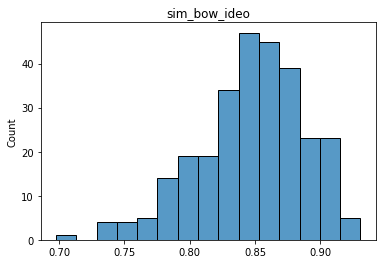

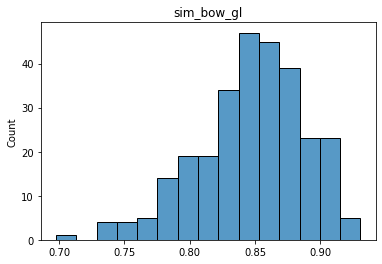

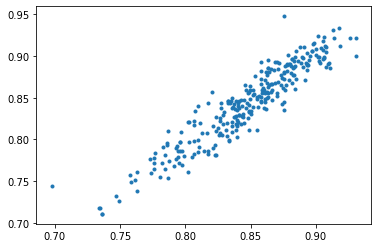

In [46]:
def similarity_to_refs(corpus, ref_indicies=[0,1]):

    sims = gensim.similarities.Similarity(output_prefix = 'workdir/',
                                          corpus=corpus,
                                          num_features=len(full_dictionary))
    
    sim_to_corpus = []
    sim_between_refs = []
    for i in ref_indicies:
        reference_array = corpus[i]
        similarity_to_refrence = sims[reference_array]
        assert similarity_to_refrence[i] > 0.99
        clean_similarity = np.delete(similarity_to_refrence, ref_indicies)
        sim_to_corpus.append(clean_similarity)
        sim_between_refs.append(similarity_to_refrence[ref_indicies]) 
        
    return sim_to_corpus, sim_between_refs
   
    
    
    
    
    
sim_name = 'bow'
new_cols = [f"sim_{sim_name}_{ref_name}" for ref_name in ref_names]
sims, ref_sims  = similarity_to_refs(corpus=full_corpus, ref_indicies=ref_indicies)
for col,sim  in zip(new_cols, sims):
    df_i[col] = sim
    
    fig, ax = plt.subplots()
    
    sns.histplot(sims[0], ax=ax)
    ax.set_title(col)
    plt.show()
    
fig, ax = plt.subplots()
ax.plot(sims[0],sims[1], '.')
plt.show()

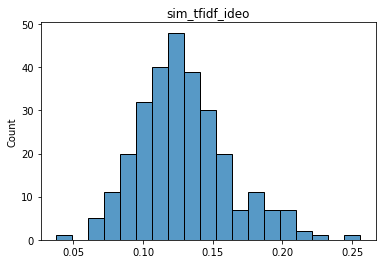

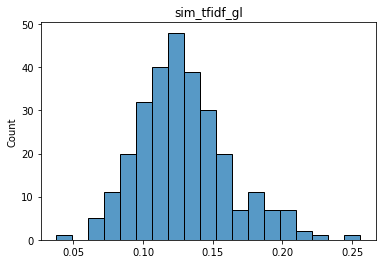

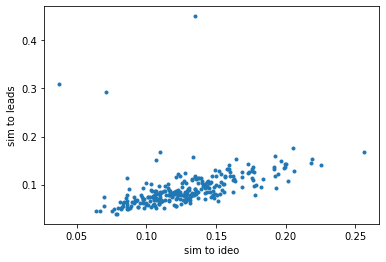

In [47]:
# 
tf_idf = gensim.models.TfidfModel(full_corpus)


sim_name = 'tfidf'
transformed_corpus = tf_idf[full_corpus]


new_cols = [f"sim_{sim_name}_{ref_name}" for ref_name in ref_names]
sims, ref_sims  = similarity_to_refs(corpus=transformed_corpus, ref_indicies=ref_indicies)
for col,sim  in zip(new_cols, sims):
    df_i[col] = sim
    
    fig, ax = plt.subplots()
    
    sns.histplot(sims[0], ax=ax)
    ax.set_title(col)
    plt.show()
    
fig, ax = plt.subplots()
ax.plot(sims[0],sims[1], '.')
ax.set_xlabel('sim to ideo')
ax.set_ylabel('sim to leads')
plt.savefig('similarity comparison.png')
plt.show()

In [48]:
df_i

,dir,sim_bow_ideo,sim_bow_gl,sim_tfidf_ideo,sim_tfidf_gl,name,org,title,year,source,url,job_title
filename,,,,,,,,,,,,
conniff_hibt_2020,how_i_built_this,0.881501,0.895962,0.151831,0.127964,Luke Holden and Ben Conniff,Luke's Lobster,How I Built Resilience: Luke Holden and Ben Co...,2020.0,hibt,https://www.happyscribe.com/public/how-i-built...,NaN
twine_hibt_2020,how_i_built_this,0.837122,0.827120,0.196671,0.148776,Nancy Twine,Briogeo,Briogeo: Nancy Twine,2020.0,hibt,https://www.happyscribe.com/public/how-i-built...,NaN
creelman_hibt_2020,how_i_built_this,0.870331,0.893035,0.255898,0.166989,Melanie Perkins and Bill Creelman,NaN,How I Built Resilience: Live with Melanie Perk...,2020.0,hibt,https://www.happyscribe.com/public/how-i-built...,NaN
lin_hibt_2020,how_i_built_this,0.880466,0.890034,0.225048,0.141460,Sandra Oh Lin,KiwiCo,How I Built Resilience: Sandra Oh Lin of KiwiCo,2020.0,hibt,https://www.happyscribe.com/public/how-i-built...,NaN
trussell_hibt_2020,how_i_built_this,0.846432,0.859243,0.099487,0.103804,Bobby Trussell,Tempur-Pedic,Tempur-Pedic: Bobby Trussell (2018),2020.0,hibt,https://www.happyscribe.com/public/how-i-built...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
mollenkopf_nyt_2020,NYT_corner_office,0.890217,0.897500,0.125911,0.102822,Steve Mollenkopf,NaN,"He’s Stared Down Activists and Apple, and Is S...",2020.0,nyt,https://www.nytimes.com/2020/02/12/business/St...,NaN
winder_nyt_2011,NYT_corner_office,0.854869,0.810755,0.148354,0.072517,Catherine Winder,NaN,Got an Idea? Sell It to Me in 30 Seconds,2011.0,nyt,https://www.nytimes.com/2011/01/02/business/02...,president and executive producer of Rainmaker...
nayar_nyt_2010,NYT_corner_office,0.821032,0.816232,0.116480,0.079424,Vineet Nayar,NaN,"He’s Not Bill Gates, or Fred Astaire",2010.0,nyt,https://www.nytimes.com/2010/02/14/business/14...,chief executive HCL Technologies


In [51]:
import altair as alt
# from vega_datasets import data

# source = data.cars()

alt.Chart(df_i).mark_circle(size=60).encode(
    x='sim_tfidf_ideo',
    y='sim_tfidf_gl',
    color='dir',
    tooltip=["name", 'title', 'year', 'source', 'url']
).interactive()

alt.Chart(...)

In [62]:
# d = df_index[df_index['dir'] == "example_articles"].sort_values(by='similarity_tfidf', ascending=False)
# d.loc[[63, 60, 65, 61, 62], ['titles', 'similarity_tfidf']]

In [63]:
# df = df_index.sort_values(by='similarity_tfidf', ascending=False)
# df.set_index('similarity_tfidf')['titles'].head(6)

## Actually pretty bad correlation between similarity scores

In [215]:
# fig, ax = plt.subplots()
# ax.plot(df_index['similarity_bow'], df_index['similarity_tfidf'], '.')
# # ax.set_xlim(0, 1)
# # ax.set_ylim(0,1)
# ax.set_ylabel('tf idf')
# ax.set_xlabel('bow word counts')
# ax.set_title('correlation between similarities')
# plt.show()

# Mess with Doc2Vec

In [64]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


In [65]:
tagged_data = [TaggedDocument(words=t, tags=[str(i)]) for i, t in enumerate(tokens)]
len(tagged_data)

272

In [67]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")

/Users/peterwinter/Work/IDEO/highlighter/.venv/lib/python3.7/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


iteration 0


/Users/peterwinter/Work/IDEO/highlighter/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [68]:
from gensim.models.doc2vec import Doc2Vec

model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
test_data = tokens[3]
v1 = model.infer_vector(test_data)
print("V1_infer", v1)

# to find most similar doc using tags
similar_doc = model.docvecs.most_similar('1')
print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
# print(model.docvecs['1'])

V1_infer [-0.64803463  1.3984768  -1.0319616   1.8962985  -0.90652204 -0.3020743
  3.4349613  -0.13617931 -1.9793631   1.9656994  -1.1473134   0.21687946
 -0.29339454  2.0907524  -0.8902498  -0.07037705 -1.8029081  -1.656823
  0.459943   -0.6966571 ]
[('49', 0.8749059438705444), ('6', 0.845335066318512), ('10', 0.8182860016822815), ('8', 0.8154927492141724), ('5', 0.8098256587982178), ('26', 0.7921580076217651), ('18', 0.7833377122879028), ('16', 0.7613852024078369), ('21', 0.7325829267501831), ('51', 0.7300896644592285)]
[ 2.5548112   2.1168988  -2.8398438   0.4853197   4.222535   -0.51300424
  1.6801506  -5.0574303  -2.6364665  -1.3751404  -1.6181151   0.21593617
  1.4740889   4.495479   -2.2989383   0.8951297  -0.9312507  -3.3247204
  2.3411107  -3.3758254 ]


In [177]:
doc_vectors = model.docvecs.vectors_docs
doc_vectors.shape

(272, 20)

In [192]:
a = norm=np.linalg.norm(doc_vectors, axis=0).reshape(1, 20)
normed_doc_vectors = (doc_vectors / a)
normed_doc_vectors.shape

(272, 20)

In [193]:
ideo_vector = model.infer_vector(ideo_doc_tokens)
gl_vector = model.infer_vector(gl_tokens)

ideo_vector = ideo_vector / np.linalg.norm(ideo_vector)
gl_vector = gl_vector / np.linalg.norm(gl_vector)

In [194]:
1 - cosine(ideo_vector, gl_vector)

0.6804723739624023

In [203]:
from scipy.spatial.distance import cosine, jensenshannon

In [209]:
ideo_doc2vec_sim = [1 - cosine(ideo_vector, doc_vectors[i]) for i in range(len(tokens))]
gl_doc2vec_sim = [1 - cosine(gl_vector, doc_vectors[i]) for i in range(len(tokens))]

# ideo_doc2vec_sim_a = [1 - jensenshannon(ideo_vector, doc_vectors[i]) for i in range(len(tokens))]
# gl_doc2vec_sim_a = [1 - jensenshannon(gl_vector, doc_vectors[i]) for i in range(len(tokens))]

In [210]:
df_file_index['gl_doc2vec_sim'] = gl_doc2vec_sim
df_file_index['ideo_doc2vec_sim'] = ideo_doc2vec_sim

# df_file_index['gl_doc2vec_sim_a'] = gl_doc2vec_sim_a
# df_file_index['ideo_doc2vec_sim_a'] = ideo_doc2vec_sim_a

In [211]:
a = cosine_similarity(doc_vectors)

<AxesSubplot:>

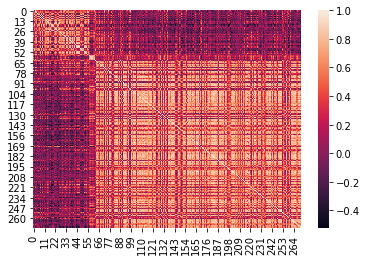

In [212]:
sns.heatmap(a)

In [214]:
alt.Chart(df_file_index).mark_circle(size=60).encode(
    x='ideo_doc2vec_sim',
    y='sim_tfidf_ideo',
    color='dir',
    tooltip=['titles', 'dir']
).interactive()

alt.Chart(...)

In [201]:
alt.Chart(df_file_index).mark_circle(size=60).encode(
    x='gl_doc2vec_sim',
    y='sim_tfidf_gl',
    color='dir',
    tooltip=['titles', 'dir']
).interactive()

alt.Chart(...)

In [202]:
alt.Chart(df_file_index).mark_circle(size=60).encode(
    x='ideo_doc2vec_sim',
    y='gl_doc2vec_sim',
    color='dir',
    tooltip=['titles', 'dir']
).interactive()

alt.Chart(...)

list